# The flow of the OCR system

#### Get the input image

In [1]:
import cv2 
import os 
image = cv2.imread(os.path.join(os.getcwd(), 'test.png'))


#### Split the image of handwritten text into rows

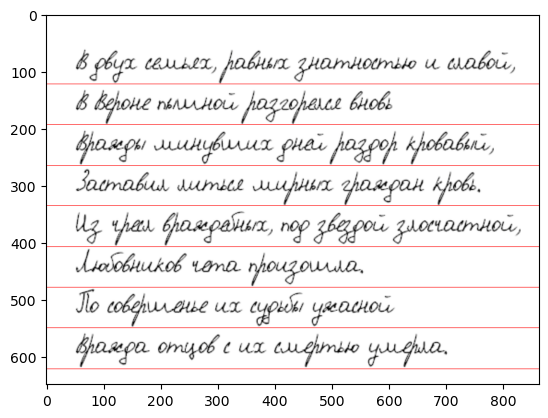

In [2]:
from matplotlib import pyplot as plt
from chunking import Process 

segmented_image, hor_lines = Process(image, vertical=False) # horizontal lines 
# segmented_image - image with text split into rows for visualisation 
# lines - pixels of where rows are split

plt.imshow(segmented_image)

#### Each row of text is passed to the process function with "vertical=True", splitting the rows into words

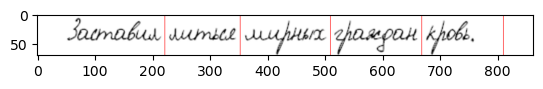

In [3]:
segmented_row, ver_lines = Process(image[hor_lines[3]:hor_lines[4]], vertical=True)

plt.imshow(segmented_row)

#### ver_lines then is filtered, and the row is split into suitable chunks to pass to the model

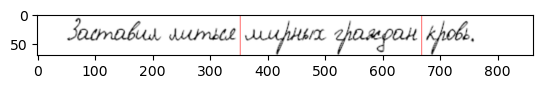

In [7]:
from chunking import VerFilter, DrawLines, Trim
import numpy as np

chunks = VerFilter(image[hor_lines[3]:hor_lines[4]], ver_lines) # the function breaks down the row into chunks

splittings = [chunk.shape[1] for chunk in chunks]
splittings = [sum(splittings[:i+1]) for i in range(len(splittings))]

plt.imshow(DrawLines(np.concatenate(chunks, axis=1), splittings, vertical=True))

#### Each chunk is passed to the model to predict the text

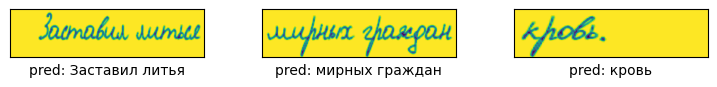

In [26]:
import torch 
from PIL import Image
from torchvision.transforms import transforms
from predict import Predict 
from ModelBuilding.RnnModel import Model
from ModelBuilding.TrainEvaluate import TransformList

ALPHABET=' %(),-./0123456789:;?[]«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё-'
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = Model(256, len(ALPHABET) + 1)
model.to(DEVICE)
model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'CNNLstm.pt'), weights_only=False, map_location=DEVICE))

transformator =transforms.Compose(TransformList().transform_list)
tensor_chunks = []

for chunk in chunks:
    
    chunk = Image.fromarray(chunk)

    chunk = transformator(chunk)

    tensor_chunks.append(chunk)

tensor_chunks = torch.stack(tensor_chunks)

predictions = Predict(model, tensor_chunks)    

num_images = tensor_chunks.size(0)
columns = len(chunks) 
rows = 1 

fig = plt.figure(figsize=(9, 1))

for i in range(num_images):

    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(tensor_chunks[i].permute(1, 2, 0)) 
    ax.set_xlabel('pred: ' + predictions[i], fontsize=10)  
    ax.yaxis.set_visible(False) 
    ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False) 

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()

#### All of the flow is enclosed in TranscribeImage function from predict

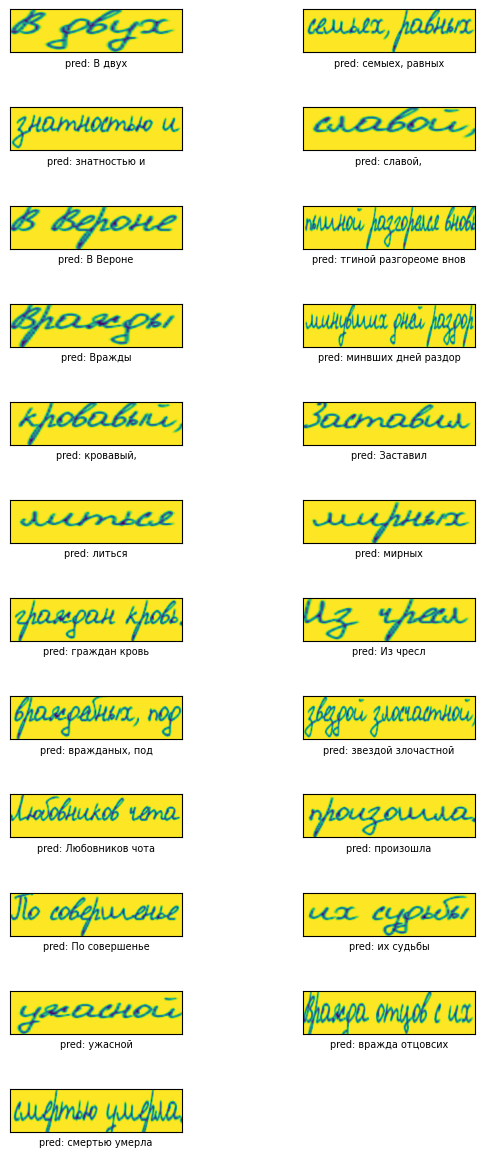

In [27]:
from predict import TranscribeImage


output = TranscribeImage(image, visualise=True)

Given the output, one may use llm to proofread and fix the errors

В двух семыех, равных знатностью и славой,
В Вероне тгиной разгореоме внов
Вражды минвших дней раздор кровавый,
Заставил литься мирных граждан кровь
Из чресл вражданых, под звездой злочастной
Любовников чота произошла
По совершенье их судьбы ужасной
вражда отцовсих смертью умерла



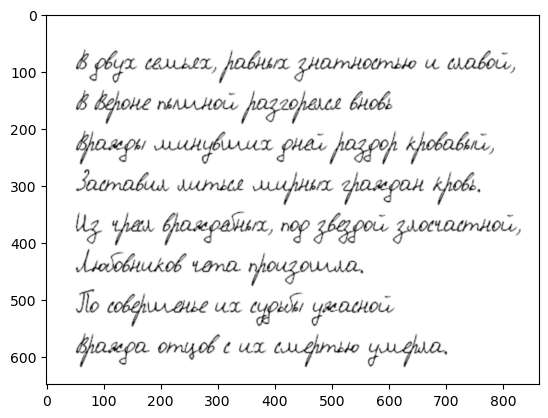

In [31]:
plt.imshow(image)
print(output)